# Supervised Learning

## Imports

Typischerweise werden Bibliotheken immer am Anfang des Codes importiert, wir werden heute allerdings etwas von der Norm abweichen und manche Sachen erst importieren, wenn wir sie benötigen

In [83]:
%matplotlib inline
from sklearn.datasets import fetch_openml, load_diabetes
import matplotlib.pyplot as plt

import numpy as np
import time
import joblib
import os



## Klassifikation

Klassifikation befasst sich damit, wie der Name sagt Daten einer festen Klasse zuzuordnen, z.B. das Bild eines Apfels der Klasse *Apfel* und das Bild einer Birne der Klasse *Birne*.

### Datenset

Es gibt mehrere Datensets die öffentlich zugänglich sind, eines davon ist das sogenannte MNIST Datenset, das handgeschriebene Ziffern beinhaltet. Die Klassen sind also die Zahlen 0-9. Zu Beginn schauen wir uns zusätzlich den Shape, also die Form unserer Daten an, um zu verstehen wie das Datenset aufgebaut ist.


In [19]:
mnist = fetch_openml('mnist_784')

# formatieren der Daten als numpy array, um sie später einfacher ansprechen und modifizieren zu können
full_data = mnist.data.to_numpy()
full_labels = mnist.target.to_numpy()
# Um etwas Zeit zu sparen, beschränken wir uns auf die ersten 1000 Bilder.
n_bilder = 1000
data = full_data[:n_bilder]
labels = full_labels[:n_bilder]
print(data.shape)
labels.shape

(1000, 784)


(1000,)

### Visualisieren der Daten

Oft ist es hilfreich bevor man sich an die eigentliche Analyse macht, den Aufbau der vorhandenen Daten anzuschauen. Hierzu benutzen wir das Modul Matplotlib, eine bekannte Bibliothek zum Erstellen von Grafiken. Bei der Visualisierung lohnt es sich darüber nachzudenken WIE man die Daten darstellen möchte. In diesem Fall ist es dankbarerweise recht einfach, da die Daten Bilder sind.

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

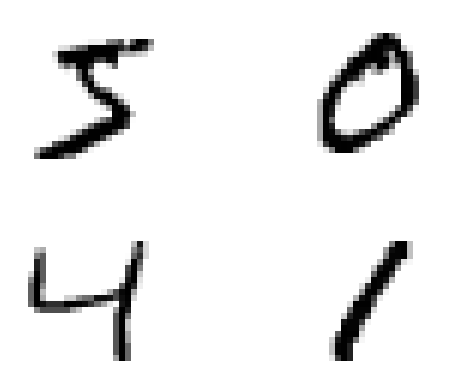

In [20]:
# Erstellen eines Bildes aus 2 x 2 untergeordneten Bildern
fig, ax = plt.subplots(2,2)
# Der 'range' Befehl erstellt eine Liste von 0 bis zur genannten Zahl, die Zahl nicht eingeschlossen, wenn man zwei Zahlen angibt, dann wird ab der ersten genannten Zahl (eingeschlossen)
#  bis zur zweiten Zahl (ausgeschlossen) eine Liste erstellt # z.B. range(4) = [0, 1, 2, 3]  range(2,4) = [2,3] 
for i in range(4):
    # bestimmen in welches Bild wir die Daten eintragen
    first = int(np.floor(i/2))
    second = int(np.floor(i % 2)) 

    # Zeigen des Bildes an der richtigen Position, hierbei werden die Daten mit 'reshape' umformatiert, sodass sie in das von der Funktion erwartete Format passen
    ax[first][second].imshow(data[i].reshape(28,28), cmap=plt.cm.gray_r)
    ax[first][second].axis('off')
ax

### Die eigentliche Klassifikation

Die Klassifikation an sich ist eigentlich sehr einfach. Wir wählen aus der von scikit-learn bereitgestellten Menge von Klassifikationsalgorithmen einen aus, hier SVM, und erstellen eine Instanz davon. Dann rufen wir auf dem Classifier 'fit' auf, wobei wir die Daten (auch oft features gennant) und die Klassen angeben.

In [21]:
from sklearn.svm import SVC

svm = SVC(decision_function_shape='ovo')
svm.fit(data, labels)


SVC(decision_function_shape='ovo')

## Und jetzt?

Wie bestimmen wir wie gut unser Modell eigentlich ist?


### 

In [22]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

predictions = svm.predict(data)
print(f'Accuracy: {np.round(accuracy_score(y_true=labels, y_pred=predictions) * 100, decimals=3)}%')
f'Balanced Accuracy: {np.round(balanced_accuracy_score(y_true=labels, y_pred=predictions)* 100, decimals=3)}%'

Accuracy: 98.2%


'Balanced Accuracy: 98.156%'

![Super!](8zm6fb.jpg)

Ein Modell ist normalerweise sehr gut an die zu trainierenden Daten angepasst. Um die wirkliche Qualität zu bestimmen, muss man auf ungesehenen Daten trainieren. Wenn wir auf ungesehenen Daten testen, wird die Genauigkeit oft wesentlich schlechter


In [25]:
test_data = full_data[10000:11000]
test_labels = full_labels[10000:11000]

def evaluate(svm, X_test, y_test):
    predictions = svm.predict(X_test)
    print(f'Accuracy: {np.round(accuracy_score(y_true=y_test, y_pred=predictions) * 100, decimals=3)}%')
    print(f'Balanced Accuracy: {np.round(balanced_accuracy_score(y_true=y_test, y_pred=predictions)* 100, decimals=3)}%')

evaluate(svm, test_data, test_labels)

Accuracy: 91.6%
Balanced Accuracy: 91.541%


Leider haben wir nicht immer den Luxus eines riesigen Datensets, was dann?

### Train Test split

Ein train test split, teilt das Datenset in einen Trainings- und einen Testteil auf. Dies ermöglicht uns die spätere Evaluation eines vollen Datensatzes

In [26]:
from sklearn.model_selection import train_test_split

t_ini = time.time()

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,random_state=42, shuffle=True, stratify=labels)

svm = SVC(decision_function_shape='ovo')
svm.fit(X_train, y_train)

evaluate(svm, X_test, y_test)
time.time()-t_ini

Accuracy: 92.5%
Balanced Accuracy: 92.221%


0.1294419765472412

### k-fold Cross Validation

Eine k-fold cross validation führt mehrere train test splits auf den Daten durch und trainiert die SVM immer wieder neu. So kann der Fehler genauer abgeschätzt werden.

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
cross_val_score(svm, data, labels, scoring=make_scorer(balanced_accuracy_score), cv=5).mean()


np.float64(0.8974902398793232)

### Wie benutze ich das weiter?

Mit Hilfe der Bibliothek 'joblib' kann ein scikit-learn Modell kann abgespeichert:

In [28]:
save_path = os.path.join('.', 'SVMModell.joblib')
joblib.dump(svm, save_path)

['.\\SVMModell.joblib']

und geladen werden:

In [29]:
svm = joblib.load(save_path)

Dann können mit Hilfe von svm.predict Vorhersagen auf neuen, unbekannten Daten getroffen werden

## Regression

Regression befasst sich mit der Vorhersage von fortlaufenden numerischen Werten, so z.B. die Zeit die zur Durchführung eines Arbeitsschritts abhängig vom Material gebraucht wird.


### Datenset

Auch hier benutzen wir wieder ein öffentlich verfügbares Datenset, das Diabetes Datenset. Im Diabetes Datenset wurden die Daten von 442 Diabetes-Patienten erfasst, um genau zu sein:

* Alter
* Geschlecht
* BMI
* durchschnittlicher Blutdruck
* total serum cholesterol
* low-density lipoproteins
* total cholesterol
* log of serum triglycerides level
* Blutzuckerniveau

Diese sollen benutzt werden um den Krankheitsverlauf im nächsten Jahr  zu bestimmen. Für den Anfang beschränken wir uns hier auf Alter und Blutzuckerniveau.

In [33]:
diabetes = load_diabetes()
full_data = diabetes.data
print(diabetes.DESCR)
target = diabetes.target
test = full_data.T
sub_data= full_data[:, [0, -1]]
print(full_data.shape)
print(sub_data.shape)
target.shape

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

(442,)

## Visualisierung

Auch hier visualisieren wir die Daten erneut, da wir uns nur auf die Spalten Alter und Blutzuckerniveau beschräneken, können wir dies in einem 3D plot visualisieren.

C:\Users\j.ihl\AppData\Local\Temp\ipykernel_4676\3177057400.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(data[0], data[1], target, marker='s', s=40, cmap='plasma')
C:\Users\j.ihl\AppData\Local\Temp\ipykernel_4676\3177057400.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


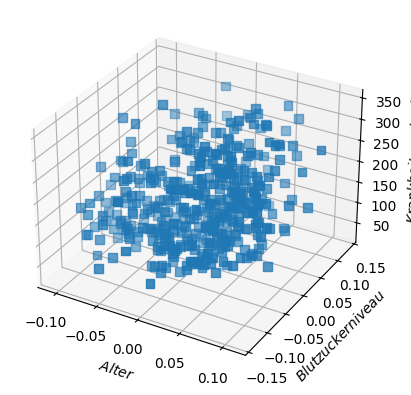

In [34]:

fig = plt.figure()
# add a single subplot
ax = fig.add_subplot(111, projection='3d')
data = sub_data.T
ax.set_xlabel(f'$Alter $')
ax.set_ylabel(f'$Blutzuckerniveau$')
ax.set_zlabel(f'$Krankheitsverlauf$')
ax.scatter(data[0], data[1], target, marker='s', s=40)
fig.show()


Alle Variablen wurden normalisiert, sodass die Summe der Quadrate 1 ergibt.

## Die eigentliche Regression

Ähnlich wie bei der Klassifikation können wir hier aus einer breiten Menge von Algorithmen wählen. Auch hier werden wir SVM verwenden. 

In [69]:
from sklearn.svm import SVR


svm = SVR()
X_train, X_test, y_train, y_test = train_test_split(sub_data, target, random_state=42, test_size = 0.2)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)



In [39]:
accuracy_score(y_true=y_test, y_pred=y_pred)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

Welche Metrik verwenden wir zur Evaluation von Regression?

In [86]:
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(y_true=y_test, y_pred = y_pred)

f'error: {rmse}, mean: {np.mean(target)}' 

'error: 70.99608543012025, mean: 152.13348416289594'